In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.signal import savgol_filter
from scipy.stats import t as tdist

In [2]:
os.makedirs('../plots/', exist_ok=True)

pl.style.use('../defaults.mplstyle')

In [3]:
models = ['CESM2', 'CESM2-ground', 'CNRM', 'NorESM', 'E3SM']

In [4]:
df = {}
for model in models:
    df[model] = pd.read_csv(f'../output/{model}.csv', index_col=0, header=[0,1])

In [5]:
df['CNRM'].rename(
    columns={
        "irr_r1i1p1f2": "IRR_01", 
        "irr_r2i1p1f2": "IRR_02", 
        "irr_r3i1p1f2": "IRR_03", 
        "irr_r4i1p1f2": "IRR_04", 
        "irr_r5i1p1f2": "IRR_05", 
        "noirr_r1i1p1f2": "NOI_01", 
        "noirr_r2i1p1f2": "NOI_02", 
        "noirr_r3i1p1f2": "NOI_03", 
        "noirr_r4i1p1f2": "NOI_04", 
        "noirr_r5i1p1f2": "NOI_05", 
    }, inplace=True
)

In [6]:
runids = {}
for model in models:
    runids[model] = []
    for expt in df[model].columns.get_level_values('experiment').unique():
        runids[model].append(expt[-2:])
    runids[model] = list(set(runids[model]))
runids

{'CESM2': ['01', '02', '03'],
 'CESM2-ground': ['01', '02', '03'],
 'CNRM': ['01', '05', '04', '02', '03'],
 'NorESM': ['01', '03'],
 'E3SM': ['01', '02']}

In [7]:
runids

{'CESM2': ['01', '02', '03'],
 'CESM2-ground': ['01', '02', '03'],
 'CNRM': ['01', '05', '04', '02', '03'],
 'NorESM': ['01', '03'],
 'E3SM': ['01', '02']}

In [8]:
erf = {}
for model in runids:
    erf[model] = {}
    if model=='CNRM':
        sw = 'rsut'
        lw = 'rlut'
    else:
        sw = 'rsnt'
        lw = 'rlnt'
    for runid in runids[model]:
        print(model, runid)
        erf[model][runid] = (
            (df[model][f'IRR_{runid}'][sw] - df[model][f'IRR_{runid}'][lw]) - 
            (df[model][f'NOI_{runid}'][sw] - df[model][f'NOI_{runid}'][lw])
        )

CESM2 01
CESM2 02
CESM2 03
CESM2-ground 01
CESM2-ground 02
CESM2-ground 03
CNRM 01
CNRM 05
CNRM 04
CNRM 02
CNRM 03
NorESM 01
NorESM 03
E3SM 01
E3SM 02


In [9]:
colors = {
    'CESM2': 'purple',
    'CESM2-ground': 'red',
    'CNRM': 'green',
    'NorESM': 'blue',
    'E3SM': 'orange'
}

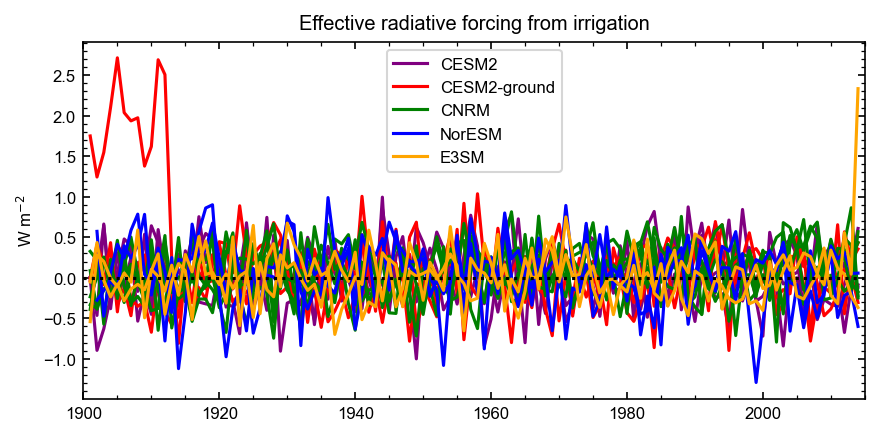

In [10]:
pl.figure(figsize=(15/2.54,7.5/2.54))
for model in runids:
    for runid in runids[model]:
        pl.plot(erf[model][runid], color=colors[model], label=model if runid=='01' else '')
pl.legend(loc='upper center')
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_raw.png')

## remove obvious outliers (found by looking at CSV)

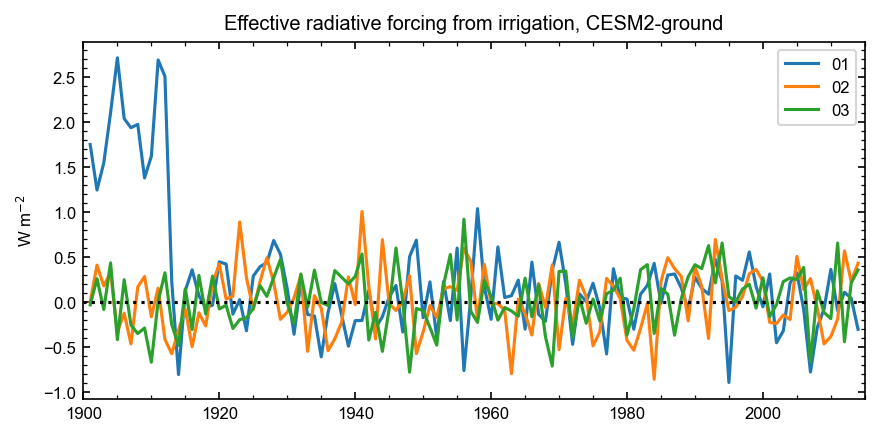

In [11]:
pl.figure(figsize=(15/2.54,7.5/2.54))
for runid in runids['CESM2-ground']:
    pl.plot(erf['CESM2-ground'][runid], label=runid)
pl.legend()
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation, CESM2-ground')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_CESM2-ground.png')

In [12]:
# 1914 is probably fine, since 1913 is OK we'll leave 1914 in
erf['CESM2-ground']['01'].loc[1901:1920]

1901    1.749925
1902    1.243433
1903    1.546348
1904    2.104201
1905    2.714137
1906    2.037885
1907    1.936127
1908    1.974147
1909    1.377988
1910    1.619651
1911    2.689974
1912    2.507202
1913    0.227848
1914   -0.809585
1915    0.125711
1916    0.355697
1917    0.068599
1918   -0.066206
1919   -0.035981
1920    0.444985
dtype: float64

In [13]:
erf['CESM2-ground']['01'].loc[1901:1912] = np.nan

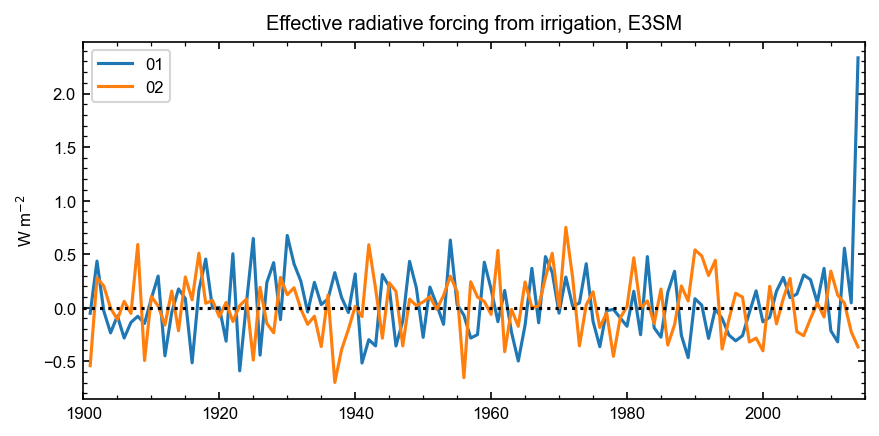

In [14]:
pl.figure(figsize=(15/2.54,7.5/2.54))
for runid in runids['E3SM']:
    pl.plot(erf['E3SM'][runid], label=runid)
pl.legend(loc='upper left')
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation, E3SM')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_E3SM.png')

In [15]:
erf['E3SM']['01'].loc[2014] = np.nan

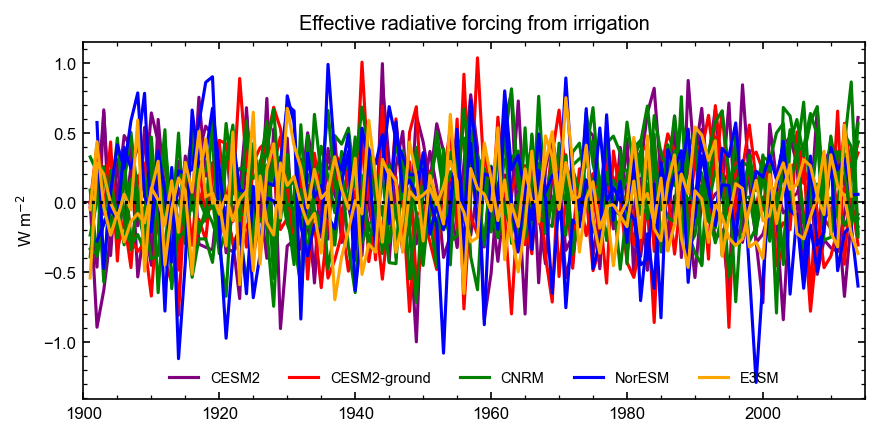

In [16]:
pl.figure(figsize=(15/2.54,7.5/2.54))
for model in runids:
    for runid in runids[model]:
        pl.plot(erf[model][runid], color=colors[model], label=model if runid=='01' else '')
pl.legend(ncol=5, fontsize=7, loc='lower center', frameon=False)
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_outliers_removed.png')

In [17]:
# find the ensemble mean
for model in runids:
    df_mean = pd.DataFrame()
    for runid in runids[model]:
        df_mean = pd.concat((df_mean, erf[model][runid].rename(runid)), axis=1)
    erf[model]['mean'] = df_mean.mean(axis=1)

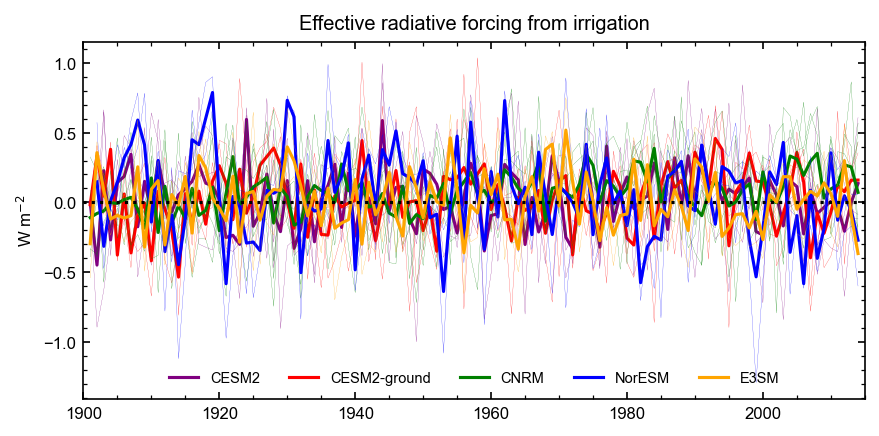

In [18]:
pl.figure(figsize=(15/2.54,7.5/2.54))
for model in runids:
    for runid in runids[model]:
        pl.plot(erf[model][runid], color=colors[model], lw=0.1)
    pl.plot(erf[model]['mean'], color=colors[model], label=model)
pl.legend(ncol=5, fontsize=7, loc='lower center', frameon=False)
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_outliers_removed_with_model_means.png')

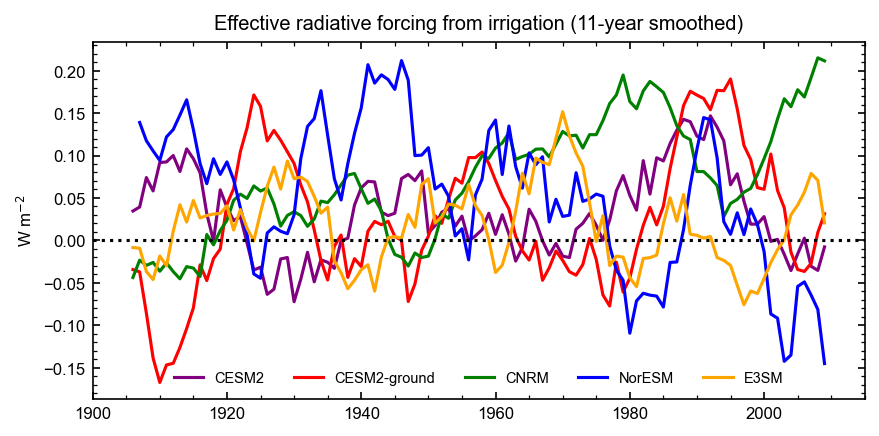

In [19]:
# create an 11-year smoothing filter
pl.figure(figsize=(15/2.54,7.5/2.54))
for model in models:
    pl.plot(
        erf[model]['mean'].index[5:-5],
        savgol_filter(erf[model]['mean'], 11, 1)[5:-5],
        color=colors[model],
        label=model
    )
pl.legend(ncol=5, fontsize=7, loc='lower center', frameon=False)
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation (11-year smoothed)')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_outliers_removed_11yr_smoothed.png')

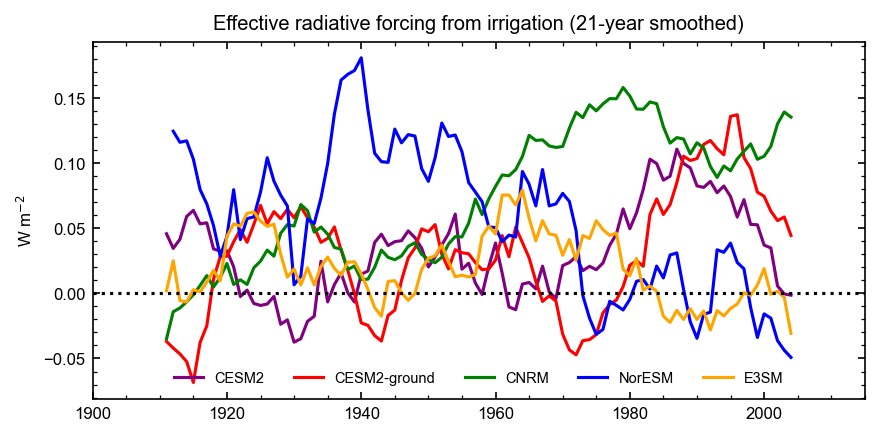

In [20]:
# create a 21-year smoothing filter
pl.figure(figsize=(15/2.54,7.5/2.54))
for model in models:
    pl.plot(
        erf[model]['mean'].index[10:-10],
        savgol_filter(erf[model]['mean'], 21, 1)[10:-10],
        color=colors[model],
        label=model
    )
pl.legend(ncol=5, fontsize=7, loc='lower center', frameon=False)
pl.axhline(0, ls=':', color='k')
pl.xlim(1900, 2015)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing from irrigation (21-year smoothed)')
pl.tight_layout()
pl.savefig('../plots/erf_irrigation_outliers_removed_21yr_smoothed.png')

In [21]:
popmean = np.ones(len(runids)) * np.nan
popstd = np.ones(len(runids)) * np.nan
for imod, model in enumerate(runids):
    popmean[imod] = erf[model]['mean'].mean()
    popstd[imod] = erf[model]['mean'].std()
    print(model, popmean[imod], popstd[imod], tdist.ppf(0.975, len(erf[model]['mean']))*popstd[imod]/np.sqrt(len(erf[model]['mean'])))
print('MMM:', np.mean(popmean))
print('MMStd:', np.sqrt(np.sum(popstd**2)))

CESM2 0.027446085087717873 0.20524814639860045 0.0380811105420364
CESM2-ground 0.02497282792397678 0.20989722107057074 0.03894368557429838
CNRM 0.0711305805263157 0.13502161082114855 0.025051494873227453
NorESM 0.04939767876106117 0.31122957407647267 0.058005029308078715
E3SM 0.014955835254324899 0.1941914304275053 0.036029681427985
MMM: 0.03758060151067928
MMStd: 0.4888646436727147


In [22]:
tdist.ppf(0.975, len(erf[model]['mean']))

np.float64(1.9809922979375063)